## Importamos los datos

In [1]:
import pandas as pd
import mord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from standard_data import *

In [2]:
# read the clean data
df = pd.read_csv('all_data_clean_oversampled_group_ordinal.csv')
print(df.shape)
df.head()

(69309, 11)


,Rating_ordinal_group,Sector_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
0,0,3,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548
1,0,6,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691
2,0,7,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861
3,0,3,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021
4,0,3,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649


In [3]:
# import the json dict_ratings_group
import json
with open('dicts_ratings_group.json', 'r') as fp:
    dict_ratings_group = json.load(fp)
dict_ratings_group

{'AAA': 0,
 'AA': 1,
 'A': 2,
 'BBB': 3,
 'BB': 4,
 'B': 5,
 'CCC': 6,
 'CC': 7,
 'D': 8}

In [4]:
var_x = var_x_num + ['Sector_ordinal']
var_y = ['Rating_ordinal_group']
df = df[var_y + var_x]
sum(df['Rating_ordinal_group'] == dict_ratings_group['D'])


7701

In [5]:
df_model = df[df['Rating_ordinal_group'] != dict_ratings_group['D']] # quitamos el caso de default
del df
df_model.head()

,Rating_ordinal_group,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,3
1,0,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,6
2,0,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,7
3,0,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,3
4,0,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,3


## Modelos

### Modelo de clasificación lineal con una variable

In [6]:
# Ejemplo de datos
var = 'Net Debt to EBITDA'

In [7]:
# usamos la funcion cut para definir los intervalos de las variables continuas
df_model[var+'_group'] = pd.cut(df_model[var], bins=7)

# Crear una tabla de frecuencia bidimensional
table_frecuencia = pd.crosstab(df_model['Rating_ordinal_group'], df_model[var+'_group'], normalize='index')*100
# round the table to 0 decimal places
table_frecuencia = table_frecuencia.round(0)
table_frecuencia

Net Debt to EBITDA_group,"(-0.0139, 1.99]","(1.99, 3.98]","(3.98, 5.97]","(5.97, 7.96]","(7.96, 9.95]","(9.95, 11.94]","(11.94, 13.93]"
Rating_ordinal_group,,,,,,,
0,62.0,19.0,14.0,2.0,0.0,2.0,2.0
1,33.0,22.0,20.0,12.0,8.0,4.0,2.0
2,32.0,30.0,23.0,8.0,4.0,2.0,1.0
3,31.0,36.0,19.0,9.0,3.0,1.0,1.0
4,32.0,40.0,18.0,6.0,2.0,1.0,1.0
5,20.0,32.0,24.0,13.0,6.0,3.0,2.0
6,26.0,30.0,19.0,11.0,7.0,5.0,2.0
7,10.0,40.0,35.0,6.0,9.0,0.0,0.0


In [8]:
# make the average of 'Debt to Assets' by Rating_ordinal_group
table_mean = df_model.groupby('Rating_ordinal_group')[var].mean().reset_index()
table_mean

,Rating_ordinal_group,Net Debt to EBITDA
0,0,2.424259
1,1,4.141263
2,2,3.568154
3,3,3.462636
4,4,3.185627
5,5,4.335870
6,6,4.288052
7,7,4.274243


Hacemos una funcion para que te lo clasifique según la media que este más cerca

In [9]:
def clasificar_valor(valor, lista_medias):
    # Calcula la diferencia absoluta entre el valor y cada media de la lista
    diferencias = [abs(valor - media) for media in lista_medias]
    # Encuentra el índice de la menor diferencia
    indice_min_diferencia = diferencias.index(min(diferencias))
    # Retorna la media más cercana usando el índice encontrado
    return indice_min_diferencia


In [10]:
# Ejemplo de uso
lista_medias =list(table_mean[var])
nuevo_valor = 0.1  # El nuevo valor a clasificar

media_mas_cercana = clasificar_valor(nuevo_valor, lista_medias)
print(f"La media más cercana a {nuevo_valor} es {media_mas_cercana}.")


La media más cercana a 0.1 es 0.


Y vemos como de bueno es este método

In [11]:
y_pred = [clasificar_valor(valor, lista_medias) for valor in df_model[var]]
y_true = df_model['Rating_ordinal_group']

In [12]:
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_true, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y_true, y_pred)
print(f"Error Absoluto Medio (MSE): {mae}")


Error Cuadrático Medio (MSE): 10.125373328139203
Error Absoluto Medio (MSE): 2.5018828723542397


In [13]:
# delete de elemets CC nad D from the list rating_order_group
rating_order_group_ = rating_order_group.copy()
rating_order_group_.remove('D')

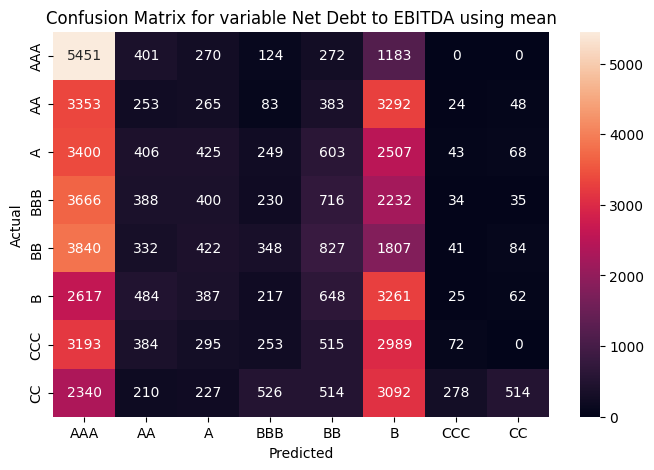

In [14]:
# plot the confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(rating_order_group_))+0.5
plt.xticks(ticks=ticks, labels=rating_order_group_)
plt.yticks(ticks=ticks, labels=rating_order_group_)
plt.title('Confusion Matrix for variable '+var+' using mean')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Podemos ver como no clasifica bein las empresas. Ahora vemos si hacemos esto mismo para todas las varaibles y a ver si alguna funciona mejor

### Modelo de clasificación lineal para todas las vaiables

In [20]:
for var in var_x:
    # compute the median of the column va by Rating_ordinal_group
    table_median = df_model.groupby('Rating_ordinal_group')[var].median()
    #table_mean = df_model.groupby('Rating_ordinal_group')[var].mean()
    
    list_clasifier =list(table_median.values)
    df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]
    print('Done',var)

Done Net Debt to EBITDA
Done Debt to Assets
Done Current Ratio
Done Quick Ratio
Done Cash ratio
Done Long Term Debt to Equity
Done Debt to Equity
Done Debt ratio
Done Financial Leverage
Done Sector_ordinal


In [21]:
# make the average and round to 0 deciclames of all the columns that are named _predicted
df_model.loc[:,'Predicted'] = df_model[[col for col in df_model.columns if '_predicted' in col]].mean(axis=1).round(0)

In [22]:
rating_order_group_ = rating_order_group.copy()
rating_order_group_.remove('D')

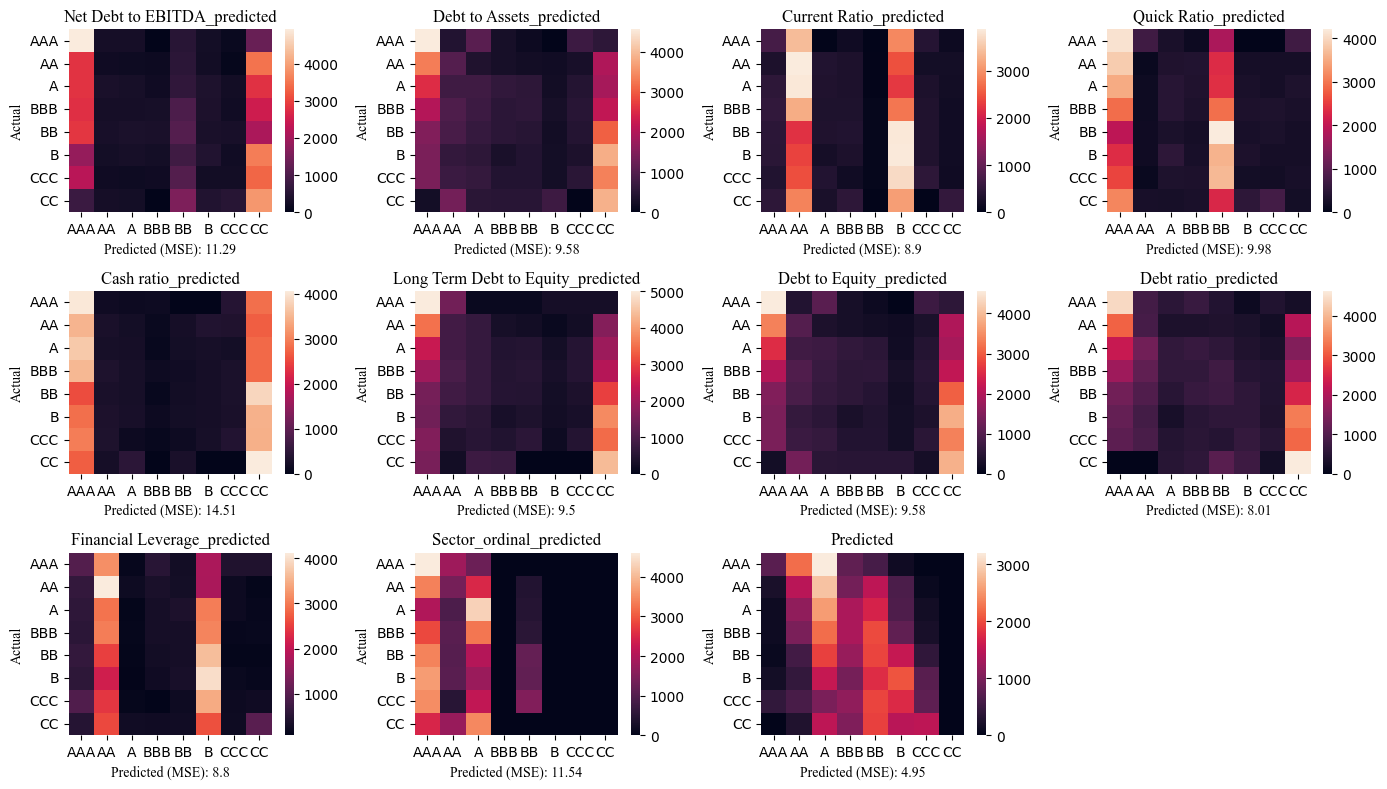

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(14, 8))

for i, var in enumerate([x for x in df_model.columns if 'edicted' in x]):
    row = i // 4
    col = i % 4
    
    y_pred = df_model[var]
    y_true = df_model['Rating_ordinal_group']
    
    cm = confusion_matrix(y_true, y_pred)
    ax = axes[row, col]
    sns.heatmap(cm, fmt="d", ax=ax)#annot=True
    ax.set_xticklabels(rating_order_group_)
    ax.set_yticklabels(rating_order_group_, rotation=0)
    
    mse = mean_squared_error(y_true, y_pred)
    # make the text in Times New Roman
    ax.set_xlabel(f"Predicted (MSE): {np.round(mse,2)}", fontname='Times New Roman')
    ax.set_ylabel('Actual', fontname='Times New Roman')
    ax.set_title(var, fontname='Times New Roman')

fig.delaxes(axes.flatten()[-1])
plt.tight_layout()
plt.savefig('plots/confusion_matrix_por_metrica.png')
plt.show()

Vemos que hemos mejorado bastante usando una combinación de varias pero  tampoco obtenemos ningun resultado bueno, provaremos con diferentes refrsiones

### Modelo de regresion  lineal para todas las varaibels

In [23]:
X = df_model[var_x] 
y = np.array(df_model['Rating_ordinal_group']) 

In [24]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# save this model
filename = 'models/model_linear_regression.sav'
pickle.dump(model, open(filename, 'wb'))

In [26]:
# Hacer predicciones
y_pred = model.predict(X_test)
# XXX Problem: al entrenar los los modelos con los datos duplicados para que esten bien ponderados, cuando haces la separaciones entre train y test los de text tiene los mismo numeros que los test

In [27]:
y_pred_rounded = np.round(y_pred, decimals=0)
set(y_pred_rounded)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}

In [28]:
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Error Absoluto Medio (MSE): {mae}")

#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred_rounded == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred_rounded - y_test) <= 1) / len(y_test),4)*100,'%')

Error Cuadrático Medio (MSE): 4.073313806677743
Error Absoluto Medio (MSE): 1.6759763178535447
Number of times it predict the exact number : 17.25 %
Number of times it predict the exact number or 1 different: 49.61 %


Nustro error sigue mejorando

In [29]:
rating_order_group_ = rating_order_group.copy()
rating_order_group_.remove('D')

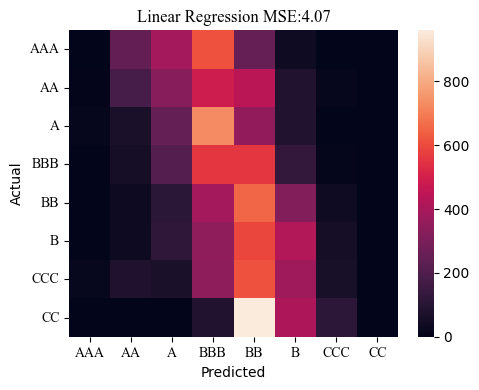

In [30]:
cm = confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
ticks = np.arange(len(rating_order_group_))+0.5
plt.xticks(ticks=ticks, labels=rating_order_group_, fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=rating_order_group_, rotation=0, fontname='Times New Roman')
plt.title(f'Linear Regression MSE:{mse:.2f}', fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_linear_regression.png')
plt.tight_layout()
plt.show()

### Regresion multinomial
Ahora probaremos con uan regresion multnomial

In [39]:
# Crear un modelo de regresión polinomial
degree = 3  # Grado del polinomio
polyreg_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg_model.fit(X_train, y_train)

# Save the polyreg_model
filename = 'models/polyreg_model.sav'
pickle.dump(polyreg_model, open(filename, 'wb'))

y_pred = polyreg_model.predict(X_test)

In [40]:
y_pred_rounded = np.round(y_pred, decimals=0)
print(set(y_pred_rounded))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, -2.0, -4.0, -3.0, -1.0}


In [42]:
# make the max between the number less that 0 equal to 0 and the number greater than 6 equal to 6
y_pred_rounded= np.clip(y_pred_rounded, 0, 7)
print(set(y_pred_rounded),set(y),rating_order_group)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0} {0, 1, 2, 3, 4, 5, 6, 7} ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'D']


In [43]:
mse = mean_squared_error(y_test, y_pred_rounded)
print(f"Error Cuadrático Medio (MSE): {mse}")
mae = mean_absolute_error(y_test, y_pred_rounded)
print(f"Error Absoluto Medio (MSE): {mae}")

#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred_rounded == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred_rounded - y_test) <= 1) / len(y_test),4)*100,'%')

Error Cuadrático Medio (MSE): 2.451550073040091
Error Absoluto Medio (MSE): 1.2165232916734297
Number of times it predict the exact number : 24.59 %
Number of times it predict the exact number or 1 different: 66.46 %


In [45]:
rating_order_group_ = rating_order_group.copy()
rating_order_group_.remove('D')

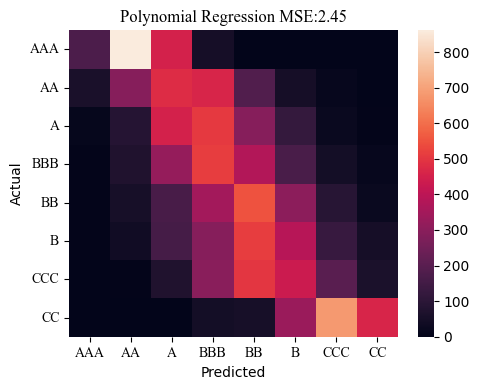

In [46]:
cm = confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d")
ticks = np.arange(len(rating_order_group_))+0.5
plt.xticks(ticks=ticks, labels=rating_order_group_, fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=rating_order_group_, rotation=0, fontname='Times New Roman')
plt.title(f'Polynomial Regression MSE:{mse:.2f}', fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_polyreg_model.png')
plt.tight_layout()
plt.show()

El caso de defaul lo hemos quitado porque no es un caso real por ahora lo hemos hecho con los grupos grande.


### Regresion ordianl

Dado que tu variable objetivo, "Rating", es categórica y tiene un orden intrínseco, y estás interesado en predecirla a partir de una serie de variables predictoras tanto numéricas como categóricas, el tipo de regresión más adecuado para tu análisis sería una regresión ordinal.

La regresión ordinal es una variante de regresión lineal que es adecuada para variables dependientes categóricas con un orden claro, como es el caso de tu variable "Rating". A diferencia de la regresión lineal clásica, que asume una variable dependiente continua, o de los modelos de clasificación como la regresión logística, que tratan con categorías sin un orden inherente, la regresión ordinal considera el orden natural entre las categorías de la variable de respuesta.

In [47]:
# Asumiendo que df es tu DataFrame y ya has transformado "sector" a numérica y "Rating" a ordinal
X = df_model[var_x]
y = df_model[var_y]

In [48]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los predictores
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Ajustar el modelo de regresión ordinal
logistic_model = mord.LogisticAT(alpha=1.0)  # LogisticAT es uno de los modelos disponibles en mord
logistic_model.fit(X_train_scaled, y_train.values)

# Save the polyreg_model
filename = 'models/logistic_model.sav'
pickle.dump(logistic_model, open(filename, 'wb'))


c:\Users\Ruben\Documents\PhD_AI\Clases\estadistica\rating_analisis\env_ratings\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# Hacer predicciones
y_pred = logistic_model.predict(X_test_scaled)

In [51]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 4.298409349131634
Mean Absolute Error: 1.6553319266352864


In [52]:
y_test = y_test.values.reshape(-1)

In [53]:
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y_test) <= 1) / len(y_test),4)*100,'%')

Number of times it predict the exact number : 18.33 %
Number of times it predict the exact number or 1 different: 51.67 %


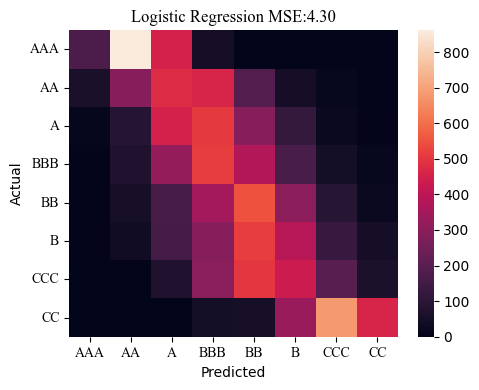

In [54]:
cm = confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d")
ticks = np.arange(len(rating_order_group_))+0.5
plt.xticks(ticks=ticks, labels=rating_order_group_, fontname='Times New Roman')
plt.yticks(ticks=ticks, labels=rating_order_group_, rotation=0, fontname='Times New Roman')
plt.title(f'Logistic Regression MSE:{mse:.2f}', fontname='Times New Roman')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix_logistic_model.png')
plt.tight_layout()
plt.show()

Para este caso obtenemos peores resultaods asi que vemos otras formas

## Modelos de ML
### Random Forest

In [35]:
import pandas as pd
import mord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from standard_data import *

from sklearn.metrics import mean_squared_error, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [36]:
# read the clean data
df = pd.read_csv('all_data_clean_oversampled_ordinal.csv') #all_data_clean_ordinal_oversampled_group
print(df.shape)

var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x = var_x_num + ['Sector_ordinal']
var_y = ['Rating_ordinal'] # ['Rating_ordinal_group']
df = df[var_y + var_x]

(65472, 11)


In [37]:
df.head()

,Rating_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,3
1,0,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,6
2,0,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,7
3,0,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,3
4,0,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,3


In [38]:
# import the json dict_ratings_group
import json
with open('dicts_ratings.json', 'r') as fp:
    dict_ratings = json.load(fp)
dict_ratings

{'AAA': 0,
 'AA+': 1,
 'AA': 2,
 'AA-': 3,
 'A+': 4,
 'A': 5,
 'A-': 6,
 'BBB+': 7,
 'BBB': 8,
 'BBB-': 9,
 'BB+': 10,
 'BB': 11,
 'BB-': 12,
 'B+': 13,
 'B': 14,
 'B-': 15,
 'CCC+': 16,
 'CCC': 17,
 'CCC-': 18,
 'CC': 19,
 'D': 20,
 'SD': 21}

In [39]:
df_model = df[df['Rating_ordinal'] < dict_ratings['D']] # quitamos el caso de default
df_model.head()

,Rating_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,3
1,0,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,6
2,0,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,7
3,0,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,3
4,0,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,3


In [40]:
X = df_model[var_x]  # Tu variable independiente, en este caso la variable 
y = np.array(df_model['Rating_ordinal'])  # Tu variable dependiente, ya codificada de 1 a 8 # convert the column 'Rating_ordinal_group' into an array

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators es el número de árboles
# Entrena el modelo
rf_model.fit(X_train, y_train)

# save the model
import joblib
joblib.dump(rf_model, 'models/rf_model.pkl')

# Realizar predicciones sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Error Absoluto Medio (MSE): {mae}")

#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y_test) / len(y_test),4)*100,'%')
# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y_test) <= 1) / len(y_test),4)*100,'%')

# Calcular la precisión en ambos conjuntos
y_train_pred = rf_model.predict(X_train)
# Predicciones en el conjunto de prueba
y_test_pred = rf_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Precisión en el conjunto de entrenamiento: {train_accuracy}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

Error Cuadrático Medio (MSE): 0.6929603494623656
Error Absoluto Medio (MSE): 0.1694388440860215
Number of times it predict the exact number : 93.85 %
Number of times it predict the exact number or 1 different: 95.89 %


Precisión en el conjunto de entrenamiento: 1.0
Precisión en el conjunto de prueba: 0.938508064516129


In [31]:
rating_order_ = All_rating_order.copy()
rating_order_.remove('D')
rating_order_.remove('SD')
print(rating_order_)

['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC']


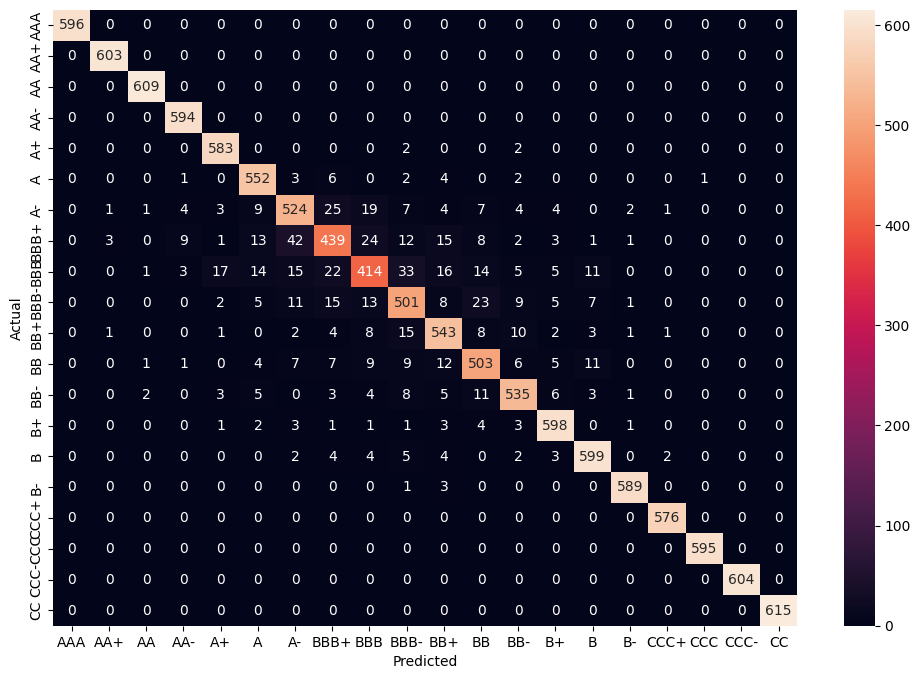

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")

ticks = np.arange(len(rating_order_))+0.5
plt.xticks(ticks=ticks, labels=rating_order_)
plt.yticks(ticks=ticks, labels=rating_order_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


XXX Ver:
Estos supuestos pueden ser también expresados de forma equivalente en términos de u.
1) El valor esperado de la perturbación aleatoria es cero E(u)=0.
2) La varianza del término error es constante para todos los valores de la variable independiente X (homocedasticidad).
3) No hay autocorrelación.  (OK)
4) El error está normalmente distribuido. 
